# **Taller Final: Predicción y Clasificación en la Industria Azucarera**


## Regresión (HISTORICO_SUERTES.xlsx): Predecir dos variables clave:

Toneladas de caña por hectárea (TCH): Indicador de la productividad de la tierra.
Porcentaje de sacarosa (%Sac.Caña): Medida de la calidad de la caña y la cantidad de azúcar extraíble.

In [176]:
# cargar librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
# crear pipeline para estandarizar las columnas numericas y codificar las categoricas
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


### Carga del dataset

In [177]:
# Cargar archivo excel con la data y crear un dataframe
df_original = pd.read_excel('HISTORICO_SUERTES.xlsx')
print(df_original.shape)

(21027, 85)


In [178]:
# creamos una copia del dataframe original
df_copy = df_original.copy()
#imprimir dimensiones  
df_copy.shape

(21027, 85)

**Se eliminan los registros donde la cosecha de cañana es para semilla**

In [179]:
# Eliminar las filas donde el valor del campo <Destino 1=Semilla> sea igual a 1, esos cortes de caña no son relevantes
df_copy = df_copy[df_copy['Destino 1=Semilla'] != 1]

**Del campo periodo se extrae el mes el cual nos podria indicar los meses de mejor produccion**

In [180]:
# Convertir de YYYYMM a MM la columna 'Período'
df_copy['Período'] = df_copy['Período'].astype(str).str[-2:]
# Cambiar el nombre de la columna 'Período' a 'Mes'
df_copy = df_copy.rename(columns={'Período': 'Mes'})

In [181]:
# Cantidad de nulos de la columna 'Mes'
print(df_copy['Mes'].isnull().sum())
# Imprimir Tipo de dato de la columna 'Mes'
print(df_copy['Mes'].dtype)
# Imprimir cantidad de datos únicos y sus frecuencias en la columna 'Mes'
print(df_copy['Mes'].value_counts())
print("Cantidad de valores únicos:", df_copy['Mes'].nunique())

0
object
Mes
01    2061
03    1992
04    1902
10    1835
08    1833
06    1822
09    1818
12    1766
07    1620
05    1422
11    1343
02    1319
Name: count, dtype: int64
Cantidad de valores únicos: 12


**Se crea el campo Edad en meses que nos indica la edad del cultivo de caña**

De esta forma podemos eliminar las dos columnas del tipo fecha 

In [182]:
# creamos una nueva columna llamada Edad con el resultado de la diferencia de estas dos columnas <F.Ult.Corte> y <F.Siembra>
df_copy['Edad'] = (df_copy['F.Ult.Corte'] - df_copy['F.Siembra']).dt.days
# Se cambia de dias a meses dividiendo entre 30
df_copy['Edad'] = df_copy['Edad'] / 30


Por la **experiencia** de varios notebook hechos y de la reunion conla experta en el dominio se acotaron las mejores variables predictoras para nuestro analisis, se eliminan las variables que no tiene relacion y las que presentan alta colinealidad 

In [183]:
# Se utilizaran estas columnas numericas para el preprocesamiento, se obtiene luego de validar datos en el notebook Desarrollo_TallerFinal_2
columnas_numericas = ['Area Neta', 'TonUltCorte', 'TCH',  '%Sac.Caña',  '%Fibra Caña', '%AR Jugo', 'Brix', 'Vejez', 'Num.Riegos', 'M3 Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias Ciclo', 'Lluvias 0 -3', 'Lluvias tres a seis', 'Lluvias seis a nueve', 'Luvias 9 -FC', '%Infest.Diatrea', 'Edad']
# Se utilizaran estas columnas categoricas para el preprocesamiento, se obtiene luego de validar datos en el notebook Desarrollo_TallerFinal_2
columnas_categoricas = ['Variedad','Producto','Cultivo','Tipo Quema','T.Corte','Mes']

Se crea un nuevo dataframe ***df_procesado*** para trabajar y si fuera el caso volver a este punto sin tener que cargar nuevamente el dataset completo

In [184]:
# Crear nuevo dataframe con las columnas seleccionadas columnas_numericas y columnas_categoricas
df_procesado = df_copy[columnas_numericas + columnas_categoricas].copy()
# imprimir dimensiones
df_procesado.shape    

(20733, 24)

In [185]:
# Mostrar de forma aleatoria 20 registros del dataframe
df_procesado.sample(20)


,Area Neta,TonUltCorte,TCH,%Sac.Caña,%Fibra Caña,%AR Jugo,Brix,Vejez,Num.Riegos,M3 Riego,Lluvias (2 Meses Ant.),Lluvias Ciclo,Lluvias 0 -3,Lluvias tres a seis,Lluvias seis a nueve,Luvias 9 -FC,%Infest.Diatrea,Edad,Variedad,Producto,Cultivo,Tipo Quema,T.Corte,Mes
13438,3.35,526.850,157.268656,11.1700,NaN,NaN,0.0000,NaN,NaN,0.00,92.0,318.0,49.0,75.0,44.0,150.0,NaN,111.233333,CC01-1940,NaN,Normal,VERDE,MECANIZADO,12
14688,2.31,248.220,107.454545,9.2740,14.5780,1.3900,11.6630,NaN,NaN,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10.000000,CC05-430,NaN,Normal,Q.ACCIDENTAL,MANUAL,05
18479,4.97,350.280,70.478873,15.0243,16.4564,0.5651,16.9625,4.113,NaN,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,53.200000,CC01-1940,BONUS 250 EC REGULADOR FISIOLOGICO,Normal,VERDE,MECANIZADO,08
19031,3.00,313.655,104.551666,12.1800,NaN,NaN,0.0000,NaN,NaN,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,43.466667,CC01-1940,NaN,Normal,VERDE,MECANIZADO,10
4648,3.35,366.950,109.537313,13.6786,16.0932,0.6867,15.8190,7.782,NaN,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,84.066667,CC85-92,BONUS 250 EC REGULADOR FISIOLÓGICO,Normal,VERDE,MECANIZADO,09
1698,4.28,569.650,133.095794,12.7000,NaN,NaN,0.0000,NaN,NaN,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,82.066667,CC85-92,NaN,Normal,NO DEF.,NO DEF.,09
19297,15.80,1764.760,111.693670,11.7463,14.1400,1.0730,13.8914,2.567,NaN,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.8248,147.133333,CC85-92,NaN,Normal,VERDE,MECANIZADO,11
13751,2.63,473.020,179.855513,12.7777,14.0890,1.0020,14.4819,33.348,NaN,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,46.500000,CC01-1940,NaN,Normal,Q.PROGRAMADA,MECANIZADO,01
8211,7.01,415.360,59.252496,12.8400,17.9970,0.7600,15.1540,NaN,NaN,0.00,0.0,0.0,0.0,0.0,0.0,0.0,3.7600,235.433333,CC85-92,NaN,Normal,NO DEF.,MANUAL,12
3457,11.04,1435.370,130.015398,12.5420,16.3335,0.4091,14.7411,2.191,3.0,43374.48,117.0,961.0,90.0,314.0,122.0,435.0,3.9495,122.400000,CC85-92,BONUS 250 EC REGULADOR FISIOLÓGICO,Normal,VERDE,MECANIZADO,04


In [186]:
# Imprimir informacion del nuevo dataframe
print(df_procesado.info())
# Imprimir total nulos por columna
print(df_procesado.isnull().sum())  

<class 'pandas.core.frame.DataFrame'>
Index: 20733 entries, 0 to 21026
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Area Neta               20733 non-null  float64
 1   TonUltCorte             20733 non-null  float64
 2   TCH                     20733 non-null  float64
 3   %Sac.Caña               20577 non-null  float64
 4   %Fibra Caña             18988 non-null  float64
 5   %AR Jugo                18903 non-null  float64
 6   Brix                    20578 non-null  float64
 7   Vejez                   18485 non-null  float64
 8   Num.Riegos              8178 non-null   float64
 9   M3 Riego                20733 non-null  float64
 10  Lluvias (2 Meses Ant.)  20733 non-null  float64
 11  Lluvias Ciclo           20733 non-null  float64
 12  Lluvias 0 -3            20733 non-null  float64
 13  Lluvias tres a seis     20733 non-null  float64
 14  Lluvias seis a nueve    20733 non-null  flo

* se parte del supuesto de que si no se indican numero de riegos es debido a que no se ejecutaron riegos al cultivo de caña
* Se parte del supuesto de que si no se indica porcentaje de infestacion es debido a que el cultivo esta limpio 
* Se parte del supuesto de que si no se indica producto es que no se utilizaron productos para la maduracion 


In [187]:
# Cambiar nulos por el valor 0 en la columna 'Num.Riegos'
df_procesado['Num.Riegos'] = df_procesado['Num.Riegos'].fillna(0)
# Cambiar nulos por el valor 0 en la columna '%Infesta.Diatrea'
df_procesado['%Infest.Diatrea'] = df_procesado['%Infest.Diatrea'].fillna(0) 
# Cambiar nulos por valor 0 en la columna 'Producto'
df_procesado['Producto']= df_procesado['Producto'].fillna(0) 
# Cambiar todos los datos diferentes de 0 en la columna 'Producto' por 1
df_procesado['Producto'] = np.where(df_procesado['Producto'] != 0, 1, 0)

In [188]:
# Imprimir shape del dataframe procesado
print(df_procesado.shape)
print('-------------------  ------------------- -------------------')
# Se imprimen nulos del dataframe df_procesado
print(df_procesado.isnull().sum())





(20733, 24)
-------------------  ------------------- -------------------
Area Neta                    0
TonUltCorte                  0
TCH                          0
%Sac.Caña                  156
%Fibra Caña               1745
%AR Jugo                  1830
Brix                       155
Vejez                     2248
Num.Riegos                   0
M3 Riego                     0
Lluvias (2 Meses Ant.)       0
Lluvias Ciclo                0
Lluvias 0 -3                 0
Lluvias tres a seis          0
Lluvias seis a nueve         0
Luvias 9 -FC                 0
%Infest.Diatrea              0
Edad                         0
Variedad                     0
Producto                     0
Cultivo                      2
Tipo Quema                   0
T.Corte                      0
Mes                          0
dtype: int64


**Se ejecuta estandarizacion de los datos, se eliminan nulos y se aplica escalas**

In [189]:
# Pipeline para estandarizar columnas numéricas y codificar columnas categóricas
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline para columnas numéricas: imputación + escalado robusto
pipeline_numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Pipeline para columnas categóricas: imputación + codificación one-hot
pipeline_categorico = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer para aplicar ambos pipelines
preprocesador = ColumnTransformer([
    ('num', pipeline_numerico, columnas_numericas),
    ('cat', pipeline_categorico, columnas_categoricas)
], remainder='passthrough')

# Aplicar el pipeline al dataframe
matriz_estandarizada = preprocesador.fit_transform(df_procesado)

# Si se desea reconstruir el DataFrame con nombres de columnas:
columnas_transformadas = preprocesador.get_feature_names_out()

# Si la matriz está en formato sparse, convertirla a densa
if hasattr(matriz_estandarizada, "toarray"):
    matriz_estandarizada = matriz_estandarizada.toarray()

# Crear el DataFrame con la matriz transformada
df_estandarizado = pd.DataFrame(
    matriz_estandarizada,
    columns=columnas_transformadas,
    index=df_procesado.index
)

# Mostrar las dimensiones y las primeras filas
print("Forma del DataFrame estandarizado:", df_estandarizado.shape)
print("\nPrimeras filas del DataFrame estandarizado:")
print(df_estandarizado.head())

Forma del DataFrame estandarizado: (20733, 98)

Primeras filas del DataFrame estandarizado:
   num__Area Neta  num__TonUltCorte  num__TCH  num__%Sac.Caña  \
0       -0.123429         -0.128060 -0.208437        0.952299   
1       -0.643429         -0.621883 -0.871021        0.324159   
2        0.132571          0.464529  1.076554       -0.298078   
3       -0.689143         -0.615510  0.168538       -0.750652   
4       -0.291429         -0.307642 -0.404996       -1.478861   

   num__%Fibra Caña  num__%AR Jugo  num__Brix  num__Vejez  num__Num.Riegos  \
0          0.864328       0.534964   0.928241   -0.000894             0.00   
1          0.878557      -0.573175   0.587915   15.881144             0.00   
2          0.099223      -0.343905  -0.135863   -0.140974             1.25   
3          1.253448      -0.114635  -0.447264   13.823727             0.00   
4         -0.535628       0.955292  -0.876580   15.255139             0.00   

   num__M3 Riego  num__Lluvias (2 Meses Ant.)  n

In [190]:
# Encontrar valores atípicos en las columnas numéricas de un DataFrame usando el método IQR

def encontrar_atipicos(df, columnas=None):
    if columnas is None:
        columnas = df.select_dtypes(include=np.number).columns
    atipicos = {}
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)][col]
        atipicos[col] = outliers
        print(f'Columna: {col} - Cantidad de atípicos: {outliers.count()}')
    return atipicos

# Ejemplo de uso:
atipicos = encontrar_atipicos(df_estandarizado)

Columna: num__Area Neta - Cantidad de atípicos: 602
Columna: num__TonUltCorte - Cantidad de atípicos: 801
Columna: num__TCH - Cantidad de atípicos: 296
Columna: num__%Sac.Caña - Cantidad de atípicos: 324
Columna: num__%Fibra Caña - Cantidad de atípicos: 784
Columna: num__%AR Jugo - Cantidad de atípicos: 710
Columna: num__Brix - Cantidad de atípicos: 1791
Columna: num__Vejez - Cantidad de atípicos: 4334
Columna: num__Num.Riegos - Cantidad de atípicos: 761
Columna: num__M3 Riego - Cantidad de atípicos: 2964
Columna: num__Lluvias (2 Meses Ant.) - Cantidad de atípicos: 413
Columna: num__Lluvias Ciclo - Cantidad de atípicos: 104
Columna: num__Lluvias 0 -3 - Cantidad de atípicos: 178
Columna: num__Lluvias tres a seis - Cantidad de atípicos: 236
Columna: num__Lluvias seis a nueve - Cantidad de atípicos: 203
Columna: num__Luvias 9 -FC - Cantidad de atípicos: 898
Columna: num__%Infest.Diatrea - Cantidad de atípicos: 3438
Columna: num__Edad - Cantidad de atípicos: 1148
Columna: cat__Variedad_CC0

In [191]:
# Imprimir Cantidad de nulos en el dataframe estandarizado
print(df_estandarizado.isnull().sum())  

num__Area Neta                  0
num__TonUltCorte                0
num__TCH                        0
num__%Sac.Caña                  0
num__%Fibra Caña                0
num__%AR Jugo                   0
num__Brix                       0
num__Vejez                      0
num__Num.Riegos                 0
num__M3 Riego                   0
num__Lluvias (2 Meses Ant.)     0
num__Lluvias Ciclo              0
num__Lluvias 0 -3               0
num__Lluvias tres a seis        0
num__Lluvias seis a nueve       0
num__Luvias 9 -FC               0
num__%Infest.Diatrea            0
num__Edad                       0
cat__Variedad_CC00-3079         0
cat__Variedad_CC00-3257         0
cat__Variedad_CC00-3771         0
cat__Variedad_CC00-3885         0
cat__Variedad_CC01-1228         0
cat__Variedad_CC01-1236         0
cat__Variedad_CC01-1940         0
cat__Variedad_CC01-385          0
cat__Variedad_CC01-678          0
cat__Variedad_CC01-746          0
cat__Variedad_CC03-1029         0
cat__Variedad_

In [192]:
# Ajustar pandas para mostrar más filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Se genera la matriz de correlacion y se lista solo los parametros para la variable objetivo en este caso **TCH**

In [193]:
# Generar matriz de correlacion y visualizar solo las correlaciones con la variables TCH
correlation_matrix = df_estandarizado.corr()
tch_correlation = correlation_matrix['num__TCH'].sort_values(ascending=False)
print(tch_correlation)  

num__TCH                        1.000000
num__TonUltCorte                0.315920
cat__Variedad_CC05-430          0.161746
num__Luvias 9 -FC               0.152464
cat__Variedad_CC01-1940         0.144041
num__%Infest.Diatrea            0.100962
num__Lluvias Ciclo              0.090074
num__M3 Riego                   0.088655
cat__Tipo Quema_VERDE           0.088232
num__Area Neta                  0.087125
num__Lluvias seis a nueve       0.071223
num__Lluvias (2 Meses Ant.)     0.065154
cat__T.Corte_MECANIZADO         0.064842
cat__Variedad_CC09-066          0.063516
cat__T.Corte_NO DEF.            0.056952
cat__Mes_07                     0.046057
cat__Producto_0                 0.040792
num__Lluvias tres a seis        0.032324
cat__Tipo Quema_NO DEF.         0.028323
cat__Variedad_CO421             0.022796
cat__Mes_09                     0.022267
cat__Variedad_CC01-1228         0.020685
cat__Cultivo_Organico           0.018127
cat__Variedad_CC01-1236         0.014556
cat__Mes_10     

Se genera matriz para validar relacion entre '**Area Neta**' y '**Toneladas Ultimo Corte**'

In [194]:
# Generar matriz de correlacion y visualizar solo las correlaciones con la variables TCH
correlation_matrix = df_estandarizado.corr()
tch_correlation = correlation_matrix['num__Area Neta'].sort_values(ascending=False)
print(tch_correlation)  

num__Area Neta                  1.000000
num__TonUltCorte                0.948861
num__M3 Riego                   0.329199
num__%Infest.Diatrea            0.271006
cat__T.Corte_MECANIZADO         0.243134
cat__Producto_1                 0.167398
cat__Tipo Quema_VERDE           0.124196
num__%Sac.Caña                  0.112636
num__Brix                       0.089418
num__TCH                        0.087125
cat__Variedad_CC01-1940         0.079296
cat__Cultivo_Organico           0.039485
cat__Mes_09                     0.033325
cat__Variedad_CC85-92           0.030632
cat__Variedad_CC82-15           0.023102
num__Edad                       0.022917
cat__Mes_06                     0.018085
cat__Variedad_CC93-4418         0.017035
cat__Mes_03                     0.015578
cat__Mes_12                     0.014326
cat__Variedad_CC05-230          0.013924
cat__Variedad_CC01-1228         0.013835
num__Num.Riegos                 0.010223
cat__Variedad_CC93-4181         0.009235
cat__Mes_10     

In [195]:
# Generar matriz de correlación y visualizar solo las correlaciones con la variable num__%Sac.Caña
correlation_matrix = df_estandarizado.corr()
tch_correlation = correlation_matrix['num__TonUltCorte'].sort_values(ascending=False)
print(tch_correlation)  

num__TonUltCorte                1.000000
num__Area Neta                  0.948861
num__M3 Riego                   0.338326
num__TCH                        0.315920
num__%Infest.Diatrea            0.283715
cat__T.Corte_MECANIZADO         0.236877
cat__Producto_1                 0.140299
cat__Tipo Quema_VERDE           0.132746
cat__Variedad_CC01-1940         0.117737
num__Brix                       0.057886
num__%Sac.Caña                  0.049304
cat__Cultivo_Organico           0.046035
cat__Variedad_CC05-430          0.037641
cat__Mes_09                     0.033516
cat__Mes_06                     0.023047
cat__Variedad_CC82-15           0.022255
cat__Variedad_CC01-1228         0.017967
cat__Mes_12                     0.015177
cat__Variedad_CC09-066          0.011435
cat__Variedad_CC05-230          0.010293
cat__Mes_10                     0.008113
num__Num.Riegos                 0.007025
cat__Mes_03                     0.005646
cat__Variedad_PR1141            0.004127
cat__Variedad_CC

Se intento eliminar la variable ***'Area Neta'*** pero esto degrado los resultados obtenidos en los modelos

In [196]:
# para pruebas , ya que existe alta correlacion entre area neta y toneladas ultimo corte
# Eliminar la columna 'num__Area Neta' del dataframe
#df_estandarizado = df_estandarizado.drop(columns=['num__Area Neta'])

Se crea dataframe para entrenar los modelos para la prediccion de ***Sacarosa***

In [197]:
# Crear nuevo dataframe llamdo df_final_SC 
df_final_SC = df_estandarizado.copy()
# Eliminar columna 'num__TCH' de un DataFrame
df_final_SC = df_final_SC.drop(columns=['num__TCH'])
print(df_final_SC.shape)
print(df_final_SC.info())   

(20733, 97)
<class 'pandas.core.frame.DataFrame'>
Index: 20733 entries, 0 to 21026
Data columns (total 97 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   num__Area Neta                20733 non-null  float64
 1   num__TonUltCorte              20733 non-null  float64
 2   num__%Sac.Caña                20733 non-null  float64
 3   num__%Fibra Caña              20733 non-null  float64
 4   num__%AR Jugo                 20733 non-null  float64
 5   num__Brix                     20733 non-null  float64
 6   num__Vejez                    20733 non-null  float64
 7   num__Num.Riegos               20733 non-null  float64
 8   num__M3 Riego                 20733 non-null  float64
 9   num__Lluvias (2 Meses Ant.)   20733 non-null  float64
 10  num__Lluvias Ciclo            20733 non-null  float64
 11  num__Lluvias 0 -3             20733 non-null  float64
 12  num__Lluvias tres a seis      20733 non-null  float64

Se crea dataframe para entrenar los modelos de prediccion de **TCH**

Se elimina la variable ***Sacarosa***, ya que es un producto del proceso dela caña y no una predictora en si misma

In [198]:
# Se eliminara la columna num__TAH porque tiene alta relacion con la variable objetivo num__TCH
df_final = df_estandarizado.copy()
# se elimina la columna num__%Sac.Caña
df_final = df_final.drop(columns=['num__%Sac.Caña'])
print(df_final.shape)

(20733, 97)


Modelo **LASSO** para el calculo de prediccion dela variable **TCH**, en este mismo bloque se busca el mejor hyperparametro para ese modelo

In [199]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Buscar el mejor valor de alpha para Lasso
alphas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
resultados_lasso = []

X = df_final.drop(columns=['num__TCH'])
y = df_final['num__TCH']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for alpha in alphas:
    modelo = Lasso(alpha=alpha, random_state=42)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    resultados_lasso.append({
        'alpha': alpha,
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
    })

import pandas as pd
df_lasso = pd.DataFrame(resultados_lasso)
print("Resultados Lasso:")
print(df_lasso.sort_values(by='R2', ascending=False))

# Buscar el mejor valor de k para KNN
from sklearn.neighbors import KNeighborsRegressor
resultados_knn = []
k_values = range(1, 21)

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    resultados_knn.append({
        'k': k,
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
    })

df_knn = pd.DataFrame(resultados_knn)
print("Resultados KNN:")
print(df_knn.sort_values(by='R2', ascending=False))

Resultados Lasso:
    alpha        R2       MAE
0   0.001  0.598206  0.342699
1   0.010  0.578624  0.349985
2   0.100  0.125424  0.567746
3   0.500 -0.001198  0.613768
4   1.000 -0.001198  0.613768
5   5.000 -0.001198  0.613768
6  10.000 -0.001198  0.613768
Resultados KNN:
     k        R2       MAE
10  11  0.280775  0.505716
12  13  0.280116  0.506684
11  12  0.279672  0.506266
13  14  0.278497  0.506648
16  17  0.278296  0.506407
17  18  0.277476  0.506780
14  15  0.277395  0.506556
19  20  0.277266  0.506734
15  16  0.277019  0.506959
9   10  0.276669  0.505294
18  19  0.276598  0.506809
8    9  0.270442  0.506099
7    8  0.262254  0.510983
6    7  0.257069  0.511856
5    6  0.250859  0.514176
4    5  0.240563  0.517415
3    4  0.218078  0.524881
2    3  0.177887  0.537060
1    2  0.083664  0.564920
0    1 -0.226236  0.643341


Se prueba modelo ***Lasso*** para la Sacarosa, se busca mejor hyperparametro

In [200]:
# Caso para Sacarosa Caña 
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Buscar el mejor valor de alpha para Lasso
alphas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
resultados_lasso_SC = []

# Eliminar columna num__TCH 


X_SC = df_final_SC.drop(columns=['num__%Sac.Caña'])
y_SC = df_final_SC['num__%Sac.Caña']

from sklearn.model_selection import train_test_split
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(X_SC, y_SC, test_size=0.2, random_state=42)

for alpha in alphas:
    modelo = Lasso(alpha=alpha, random_state=42)
    modelo.fit(X_train_SC, y_train_SC)
    y_pred = modelo.predict(X_test_SC)
    resultados_lasso_SC.append({
        'alpha': alpha,
        'R2': r2_score(y_test_SC, y_pred),
        'MAE': mean_absolute_error(y_test_SC, y_pred),
    })

import pandas as pd
df_lasso_SC = pd.DataFrame(resultados_lasso_SC)
print("Resultados Lasso Sacarosa Caña:")    
print(df_lasso_SC.sort_values(by='R2', ascending=False))

Resultados Lasso Sacarosa Caña:
    alpha        R2       MAE
0   0.001  0.476392  0.422082
1   0.010  0.431885  0.443418
2   0.100  0.231768  0.526232
3   0.500  0.020017  0.598848
4   1.000 -0.000085  0.605495
5   5.000 -0.000085  0.605495
6  10.000 -0.000085  0.605495


Se prueba modelo ***Ridge*** para la Sacarosa

In [201]:
# Utilizar el método Ridge en un pipeline para el análisis
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error

# Crear pipeline para Ridge con alpha=1.0 (puedes ajustar este valor)
pipeline_ridge = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('regressor', Ridge(alpha=0.01, random_state=42))
])

# Ajustar el pipeline
pipeline_ridge.fit(X_train_SC, y_train_SC)
y_pred_ridge_SC = pipeline_ridge.predict(X_test_SC)

# Calcular métricas
r2_ridge = r2_score(y_test_SC, y_pred_ridge_SC)
mae_ridge = mean_absolute_error(y_test_SC, y_pred_ridge_SC)

print("Ridge Pipeline (alpha=0.01):")
print(f"R2: {r2_ridge:.4f}")
print(f"MAE: {mae_ridge:.4f}")

Ridge Pipeline (alpha=0.01):
R2: 0.4774
MAE: 0.4211


In [219]:
# Graficar los coeficientes del modelo Lasso en orden descendente y mostrar etiquetas y valores

import matplotlib.pyplot as plt
import numpy as np

# Obtener coeficientes y nombres de variables
coeficientes = modelo.named_steps['regressor'].coef_
nombres = X.columns

# Filtrar coeficientes diferentes de 0
indices_no_cero = coeficientes != 0
coef_no_cero = coeficientes[indices_no_cero]
nombres_no_cero = nombres[indices_no_cero]

# Ordenar de mayor a menor
orden = np.argsort(coef_no_cero)[::-1]
coef_ordenados = coef_no_cero[orden]
nombres_ordenados = nombres_no_cero[orden]

plt.figure(figsize=(8, 10))
barras = plt.barh(nombres_ordenados, coef_ordenados, color='skyblue')
plt.xlabel("Valor del coeficiente")
plt.title("Coeficientes del modelo Lasso (orden descendente)")

# Añadir los valores numéricos en las barras
for barra, valor in zip(barras, coef_ordenados):
    plt.text(barra.get_width(), barra.get_y() + barra.get_height()/2, f'{valor:.3f}', va='center')

plt.gca().invert_yaxis()  # Para que el mayor quede arriba
plt.tight_layout()
plt.show()

AttributeError: 'Lasso' object has no attribute 'named_steps'

Modelo **LASSO** para **SACAROSA** aplicando **VC**

In [211]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Crear el modelo Lasso con el mejor alpha encontrado
modelo_lasso = Lasso(alpha=0.001, random_state=42)

# Validación cruzada con 5 folds y métrica R2
scores = cross_val_score(modelo_lasso, X_SC, y_SC, cv=5, scoring='r2')

print("R2 por fold:", scores)
print("R2 promedio CV:", scores.mean())
print("R2 std CV:", scores.std())

R2 por fold: [0.14564143 0.36325992 0.48292639 0.41995278 0.50948946]
R2 promedio CV: 0.38425399561268564
R2 std CV: 0.12966979100171402


Se prueba modelo ***RandomForest*** para el modelo de prediccion de ***sacarosa***

In [202]:
X_SC.sample(10)

,num__Area Neta,num__TonUltCorte,num__%Fibra Caña,num__%AR Jugo,num__Brix,num__Vejez,num__Num.Riegos,num__M3 Riego,num__Lluvias (2 Meses Ant.),num__Lluvias Ciclo,num__Lluvias 0 -3,num__Lluvias tres a seis,num__Lluvias seis a nueve,num__Luvias 9 -FC,num__%Infest.Diatrea,num__Edad,cat__Variedad_CC00-3079,cat__Variedad_CC00-3257,cat__Variedad_CC00-3771,cat__Variedad_CC00-3885,cat__Variedad_CC01-1228,cat__Variedad_CC01-1236,cat__Variedad_CC01-1940,cat__Variedad_CC01-385,cat__Variedad_CC01-678,cat__Variedad_CC01-746,cat__Variedad_CC03-1029,cat__Variedad_CC03-469,cat__Variedad_CC04-195,cat__Variedad_CC04-667,cat__Variedad_CC05-230,cat__Variedad_CC05-231,cat__Variedad_CC05-430,cat__Variedad_CC06-783,cat__Variedad_CC06-791,cat__Variedad_CC09-066,cat__Variedad_CC09-235,cat__Variedad_CC09-449,cat__Variedad_CC09-535,cat__Variedad_CC09-702,cat__Variedad_CC10-450,cat__Variedad_CC11-2132,cat__Variedad_CC11-595,cat__Variedad_CC11-600,cat__Variedad_CC11-605,cat__Variedad_CC12-2120,cat__Variedad_CC15-2356,cat__Variedad_CC15-2495,cat__Variedad_CC82-15,cat__Variedad_CC84-75,cat__Variedad_CC85-92,cat__Variedad_CC91-1606,cat__Variedad_CC92-2198,cat__Variedad_CC92-2804,cat__Variedad_CC93-3895,cat__Variedad_CC93-4181,cat__Variedad_CC93-4418,cat__Variedad_CC97-7170,cat__Variedad_CC98-72,cat__Variedad_CC99-2461,cat__Variedad_CO421,cat__Variedad_MZC74-275,cat__Variedad_PR1141,cat__Variedad_PR1248,cat__Variedad_PR61-632,cat__Variedad_Q191,cat__Variedad_Q208,cat__Variedad_RB73-2223,cat__Variedad_RB85-5113,cat__Variedad_RD75-11,cat__Variedad_SP71-6949,cat__Variedad_V71-51,cat__Variedad_VARIAS,cat__Producto_0,cat__Producto_1,cat__Cultivo_Normal,cat__Cultivo_Organico,cat__Tipo Quema_NO DEF.,cat__Tipo Quema_Q.ACCIDENTAL,cat__Tipo Quema_Q.PROGRAMADA,cat__Tipo Quema_VERDE,cat__T.Corte_MANUAL,cat__T.Corte_MECANIZADO,cat__T.Corte_NO DEF.,cat__Mes_01,cat__Mes_02,cat__Mes_03,cat__Mes_04,cat__Mes_05,cat__Mes_06,cat__Mes_07,cat__Mes_08,cat__Mes_09,cat__Mes_10,cat__Mes_11,cat__Mes_12
7919,-0.694857,-0.616638,-1.068137,-0.114635,0.860228,6.664433,0.00,0.000000,-0.138462,-0.472885,-0.304545,-0.319048,-0.319048,-0.237736,0.000000,-0.286132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7175,-0.220571,-0.208354,-1.502682,0.057318,0.315993,2.995979,1.75,2.200821,0.661538,0.556399,1.618182,0.009524,1.314286,0.192453,8.137422,-0.218256,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2757,0.940571,0.905264,-0.311351,0.162400,0.363941,3.168454,0.50,0.867216,0.861538,0.068330,-0.304545,0.600000,0.209524,0.498113,2.334524,0.417203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7938,0.646857,0.940501,0.000000,0.000000,-9.330000,0.000000,1.50,4.172268,1.323077,0.288503,0.245455,0.852381,0.238095,0.584906,2.628682,0.445875,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12750,0.385143,0.695833,0.000000,0.000000,-9.330000,0.000000,0.00,0.000000,0.238462,-0.002169,0.136364,-0.290476,-0.319048,1.011321,0.000000,-0.

Se intento suavizar los valores atipicos para ver si tenia algun impacto directo en este caso pero no se logro

In [203]:
def recortar_atipicos_percentil(df, columnas=None, lower=0.05, upper=0.95):
    df_recortado = df.copy()
    if columnas is None:
        columnas = df.select_dtypes(include=np.number).columns
    for col in columnas:
        p_lower = df[col].quantile(lower)
        p_upper = df[col].quantile(upper)
        df_recortado[col] = df[col].clip(lower=p_lower, upper=p_upper)
    return df_recortado

# Ejemplo de uso:
#X_SC = recortar_atipicos_percentil(X_SC)

In [204]:
# Validación cruzada (K-Fold) para Random Forest en la predicción de Sacarosa (%Sac.Caña)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

modelo_rf_SC = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=42
)

# Realizar validación cruzada con 5 folds y métrica R2
scores_rf_SC = cross_val_score(modelo_rf_SC, X_SC, y_SC, cv=5, scoring='r2')

print("R2 por fold:", scores_rf_SC)
print("R2 promedio CV:", scores_rf_SC.mean())
print("R2 std CV:", scores_rf_SC.std())

R2 por fold: [0.78205193 0.86510574 0.87181291 0.76594255 0.90848264]
R2 promedio CV: 0.8386791560420411
R2 std CV: 0.05507448222091201


Calculo coeficientes del modelo ***LASSO*** para generar grafica

In [205]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Crear pipeline para Lasso con alpha=0.001
pipeline_lasso = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('regressor', Lasso(alpha=0.001, random_state=42))
])

# Ajustar el pipeline
pipeline_lasso.fit(X_train, y_train)
y_pred_lasso = pipeline_lasso.predict(X_test)

# Calcular métricas
r2 = r2_score(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)

print("Lasso Pipeline (alpha=0.001):")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")

Lasso Pipeline (alpha=0.001):
R2: 0.5982
MAE: 0.3427


Grafica coeficientes modelo ***LASSO*** para el **TCH**

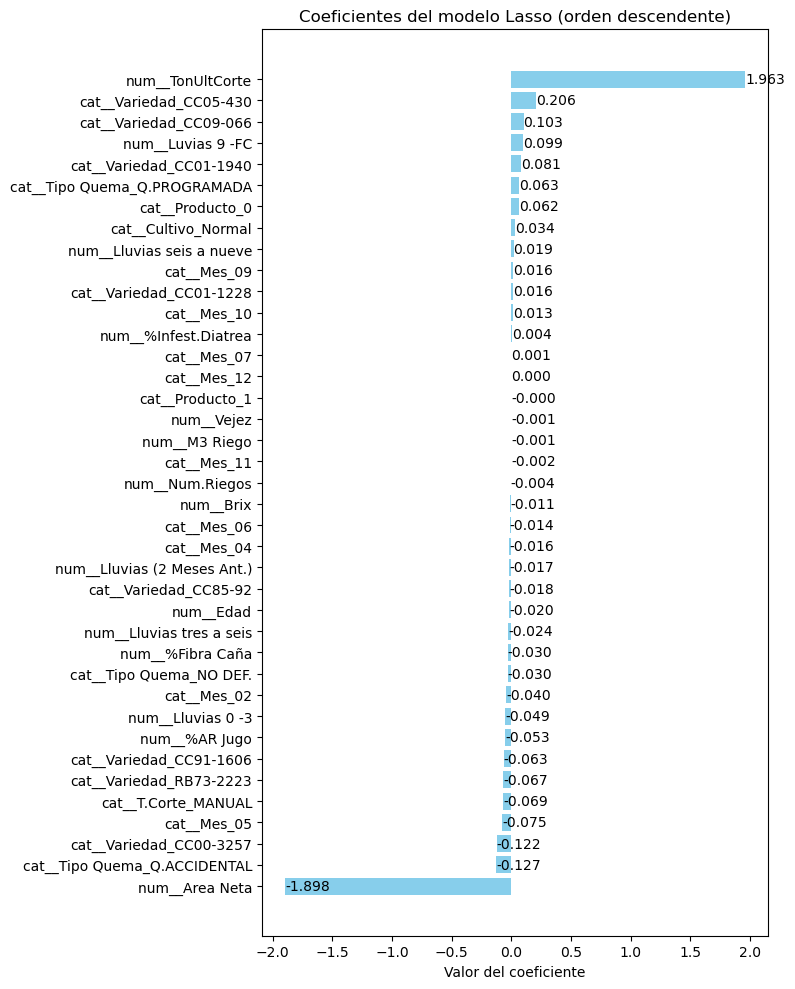

In [206]:
# Graficar los coeficientes del modelo Lasso en orden descendente y mostrar etiquetas y valores

import matplotlib.pyplot as plt
import numpy as np

# Obtener coeficientes y nombres de variables
coeficientes = pipeline_lasso.named_steps['regressor'].coef_
nombres = X.columns

# Filtrar coeficientes diferentes de 0
indices_no_cero = coeficientes != 0
coef_no_cero = coeficientes[indices_no_cero]
nombres_no_cero = nombres[indices_no_cero]

# Ordenar de mayor a menor
orden = np.argsort(coef_no_cero)[::-1]
coef_ordenados = coef_no_cero[orden]
nombres_ordenados = nombres_no_cero[orden]

plt.figure(figsize=(8, 10))
barras = plt.barh(nombres_ordenados, coef_ordenados, color='skyblue')
plt.xlabel("Valor del coeficiente")
plt.title("Coeficientes del modelo Lasso (orden descendente)")

# Añadir los valores numéricos en las barras
for barra, valor in zip(barras, coef_ordenados):
    plt.text(barra.get_width(), barra.get_y() + barra.get_height()/2, f'{valor:.3f}', va='center')

plt.gca().invert_yaxis()  # Para que el mayor quede arriba
plt.tight_layout()
plt.show()

In [207]:
# Utilizar el método Ridge en un pipeline para el análisis
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error

# Crear pipeline para Ridge con alpha=1.0 (puedes ajustar este valor)
pipeline_ridge = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])

# Ajustar el pipeline
pipeline_ridge.fit(X_train, y_train)
y_pred_ridge = pipeline_ridge.predict(X_test)

# Calcular métricas
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print("Ridge Pipeline (alpha=1.0):")
print(f"R2: {r2_ridge:.4f}")
print(f"MAE: {mae_ridge:.4f}")

Ridge Pipeline (alpha=1.0):
R2: 0.6011
MAE: 0.3426


In [208]:
# Validación cruzada para el método Ridge
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

modelo_ridge = Ridge(alpha=1.0, random_state=42)
scores_ridge = cross_val_score(modelo_ridge, X, y, cv=5, scoring='r2')

print("R2 por fold:", scores_ridge)
print("R2 promedio CV:", scores_ridge.mean())
print("R2 std CV:", scores_ridge.std())

R2 por fold: [0.47398533 0.55881285 0.57492106 0.55017955 0.50146761]
R2 promedio CV: 0.5318732820261872
R2 std CV: 0.03791962793663931


In [209]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Crear el modelo Lasso con el mejor alpha encontrado
modelo_lasso = Lasso(alpha=0.001, random_state=42)

# Validación cruzada con 5 folds y métrica R2
scores = cross_val_score(modelo_lasso, X, y, cv=5, scoring='r2')

print("R2 por fold:", scores)
print("R2 promedio CV:", scores.mean())
print("R2 std CV:", scores.std())

R2 por fold: [0.50519103 0.55659502 0.56956941 0.54764976 0.50463307]
R2 promedio CV: 0.536727656824177
R2 std CV: 0.02689686473264088


In [210]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo
rf = RandomForestRegressor(random_state=42).queNOejecutes # se marca para que no ejecute ya que toma al rededor de una hora en ejecutarse

# Definir el grid de parámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar la búsqueda de grilla con validación cruzada
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Ejecutar la búsqueda
grid_search.fit(X, y)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score R2:", grid_search.best_score_)

AttributeError: 'RandomForestRegressor' object has no attribute 'queNOejecutes'

Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Mejor score R2: 0.9695871237114282

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Crear el modelo Random Forest con n_estimators=300 (puedes ajustar este valor)
modelo_rf = RandomForestRegressor(n_estimators=300,max_depth=None, min_samples_leaf=2,min_samples_split=2,random_state=42)

# Validación cruzada con 5 folds y métrica R2
scores_rf = cross_val_score(modelo_rf, X, y, cv=5, scoring='r2')

print("R2 por fold:", scores_rf)
print("R2 promedio CV:", scores_rf.mean())
print("R2 std CV:", scores_rf.std())

KeyboardInterrupt: 

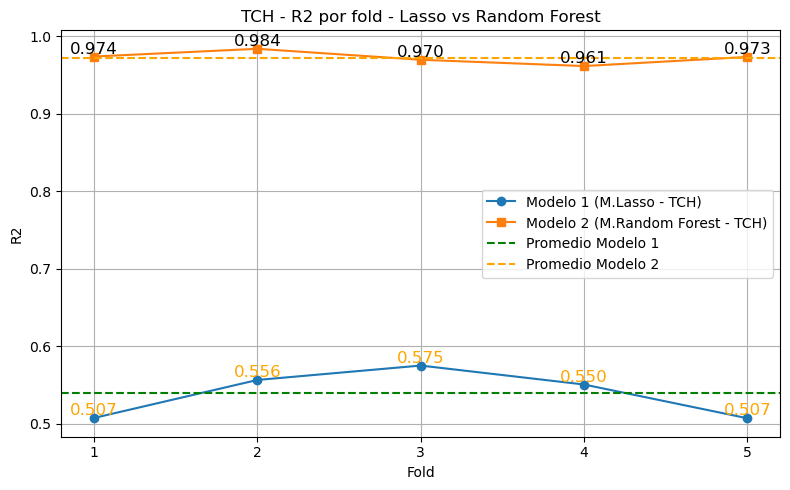

In [217]:
# Graficar las métricas R2 por fold para dos modelos Random Forest

import matplotlib.pyplot as plt
import numpy as np

# Resultados de los dos modelos
r2_folds_modelo2 = [0.97374874, 0.98371132, 0.9695579, 0.96144016, 0.97320569]
r2_folds_modelo1 = [0.50714912, 0.55621346, 0.57479878, 0.55034321, 0.5067818]

folds = np.arange(1, 6)

plt.figure(figsize=(8, 5))
plt.plot(folds, r2_folds_modelo1, marker='o', label='Modelo 1 (M.Lasso - TCH)')
plt.plot(folds, r2_folds_modelo2, marker='s', label='Modelo 2 (M.Random Forest - TCH)')
plt.axhline(np.mean(r2_folds_modelo1), color='green', linestyle='--', label='Promedio Modelo 1')
plt.axhline(np.mean(r2_folds_modelo2), color='orange', linestyle='--', label='Promedio Modelo 2')

# Imprimir el valor de cada fold en la gráfica
for x, y in zip(folds, r2_folds_modelo1):
    plt.text(x, y, f'{y:.3f}', color='orange', fontsize=12, ha='center', va='bottom')
for x, y in zip(folds, r2_folds_modelo2):
    plt.text(x, y, f'{y:.3f}', color='black', fontsize=12, ha='center', va='bottom')


plt.title('TCH - R2 por fold - Lasso vs Random Forest')
plt.xlabel('Fold')
plt.ylabel('R2')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

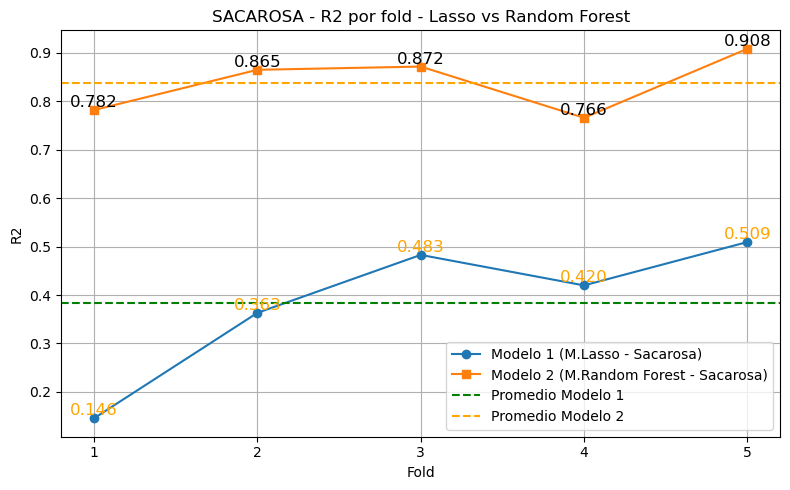

In [218]:
# Graficar las métricas R2 por fold para dos modelos Random Forest SACAROSA

import matplotlib.pyplot as plt
import numpy as np

# Resultados de los dos modelos
r2_folds_modelo1 = [0.14564143, 0.36325992, 0.48292639, 0.41995278, 0.50948946]
r2_folds_modelo2 = [0.78205193, 0.86510574, 0.87181291, 0.76594255, 0.90848264]

folds = np.arange(1, 6)

plt.figure(figsize=(8, 5))
plt.plot(folds, r2_folds_modelo1, marker='o', label='Modelo 1 (M.Lasso - Sacarosa)')
plt.plot(folds, r2_folds_modelo2, marker='s', label='Modelo 2 (M.Random Forest - Sacarosa)')
plt.axhline(np.mean(r2_folds_modelo1), color='green', linestyle='--', label='Promedio Modelo 1')
plt.axhline(np.mean(r2_folds_modelo2), color='orange', linestyle='--', label='Promedio Modelo 2')

# Imprimir el valor de cada fold en la gráfica
for x, y in zip(folds, r2_folds_modelo1):
    plt.text(x, y, f'{y:.3f}', color='orange', fontsize=12, ha='center', va='bottom')
for x, y in zip(folds, r2_folds_modelo2):
    plt.text(x, y, f'{y:.3f}', color='black', fontsize=12, ha='center', va='bottom')


plt.title('SACAROSA - R2 por fold - Lasso vs Random Forest')
plt.xlabel('Fold')
plt.ylabel('R2')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Resultado de RandomForestRefressor

    R2 por fold: [0.97165808 0.9804887  0.96592725 0.9606958  0.96916579]

    R2 promedio CV: 0.9695871237114282

    R2 std CV: 0.006569035553010742

A pesar de la alta colinealidad entre las variables "área neta" y "toneladas último corte", se optó por mantener ambas en el modelo predictivo. Esto se debe a que su combinación mejora la capacidad de predicción, y la eliminación de una de ellas reduce el rendimiento del modelo en aproximadamente un 50%. Tras evaluar varios modelos de regresión regularizada (Lasso, Ridge y Elastic Net), se determinó que **Lasso es el modelo óptimo** para este caso de uso, ya que mostró los resultados más estables en las pruebas de validación cruzada (k-fold).

Adicionalmente, se probó el modelo **Random Forest Regressor**, que superó significativamente al modelo Lasso. Este modelo elevó la capacidad de explicación de los casos del 53% a casi un 97%, demostrando su **superioridad para este problema de predicción**. 
